In [ ]:
#**************************************************************************************
#
#    Title: <YoanoGAN-OOP>
#    Author: <Ege Demir>
#    Date: <6/26/1011>
#    Code version: <0.1>
#
#**************************************************************************************


In [ ]:
import glob
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers 
import time
import tensorflow as tf
from IPython import display
from IPython.display import clear_output
from keras.initializers import RandomNormal
from PIL import Image
from datetime import datetime

# Load and prepare dataset

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [ ]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels  = tf.keras.utils.to_categorical(test_labels,  10)

In [ ]:
amount_to_Cut = int(np.floor((np.ma.size(train_images,axis=0)/BATCH_SIZE))*BATCH_SIZE)

train_images = train_images[:amount_to_Cut,:,:]
train_labels = train_labels[:amount_to_Cut,:]


In [ ]:
train_images = (train_images) / 256  # Normalize the images to [0, 1]
train_images = train_images.astype(np.float32)

test_images = (test_images) / 256
test_images = test_images.astype(np.float32)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 0.10000002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)>

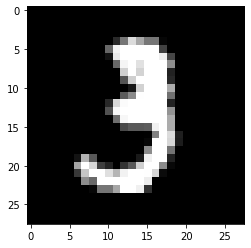

In [ ]:
plt.plot()
plt.imshow(train_images[10,:, :], cmap='gray')
#(tf.ones_like(train_labels[10])-train_labels[10])/9
tf.ones_like(train_labels[10])-(train_labels[10]*0.9)

In [ ]:
# Batch and shuffle the data
dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_Output = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

# Custom Layers

# Custom Models

## Generator

In [ ]:
def make_generator_model(latent_dim,class_Amt):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim+class_Amt,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

## Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(10))

    return model

# Define Loss and Optimizers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy_categorical = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cross_entropy_binary = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def discriminator_loss(y_pred,y_real):
    return cross_entropy_categorical(y_real,y_pred)

In [ ]:
def generator_loss(y_pred,y_real):


    indices = tf.math.argmax(y_real,axis=1)

    arr = []
    for i in range(BATCH_SIZE):
      arr.append(y_pred[i,indices[i]])

    final_cross_entropy = cross_entropy_binary(tf.zeros_like(indices),arr)
    
    return final_cross_entropy






# Define Callbacks

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=0,
    write_graph=False,
    write_images=True,
    write_steps_per_second=False,
    update_freq=100,
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)


# Define training loop

In [ ]:
EPOCHS = 500
noise_dim = 128
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

rand_y = [0,1,2,3,4,5,6,7,8]
rand_y = tf.keras.utils.to_categorical(rand_y, 10)
#print(rand_y)
#rand_y = np.append(np.ones((num_examples_to_generate,1)),np.zeros((num_examples_to_generate, 9)),axis=1)

seed = np.append(rand_y,tf.random.normal([num_examples_to_generate, noise_dim]),axis=1)


In [ ]:
class YoanoGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim,lmbd=0.7):
        super(YoanoGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        
        self.currentBatch = 0
        
        self.latent_dim = latent_dim
        self.lmbd = lmbd
        
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.norm_tracker = tf.keras.metrics.Mean(name="gen_output_norm")
        self.w_noise_accuracy_tracker = tf.keras.metrics.Mean(name="w_noise_accuracy")
        self.wo_noise_accuracy_tracker = tf.keras.metrics.Mean(name="wo_noise_accuracy")
        
        
    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker,self.norm_tracker,self.w_noise_accuracy_tracker,self.wo_noise_accuracy_tracker]
    
    def get_accuracy(self,x,y_real):
        x = tf.cast(x,tf.int64)
        y_real = tf.cast(y_real,tf.int64)
        
        predictions = tf.math.argmax(self.discriminator(x),output_type=tf.dtypes.int64,axis=1)
        return (tf.math.count_nonzero(tf.math.argmax(y_real,axis=1)-predictions))/(tf.cast(tf.shape(x)[0],tf.int64))
    
    def get_norm(self,noise):
        norm_calculated = tf.norm(noise,ord=2,axis=[1,2])
        norm_mean = tf.math.reduce_mean(norm_calculated)
        return norm_mean
    
    def compile(self, d_optimizer, g_optimizer, dis_loss_fn, gen_loss_fn):
        super(YoanoGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.dis_loss_fn = dis_loss_fn
        self.gen_loss_fn = gen_loss_fn

    def train_step(self, data):
        
        self.currentBatch = self.currentBatch + 1
        
        #Import data and infer batch size
        x, y = data
        BATCH_SIZE = tf.shape(x)[0]
        
        #Cast x to float32 to match with generator output type (Otherwise adding the two gives an error) 
        x = tf.cast(x, tf.float32)
        
        #Append normal noise and one hot labeled y data together for generator input.
        gen_in = tf.experimental.numpy.append(y, tf.random.normal([BATCH_SIZE, self.latent_dim]), axis=1)
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            #Run the generator and generate noises
            generated_noise = self.generator(gen_in, training=True)
            generated_noise = tf.squeeze(generated_noise * self.lmbd) #Squeezing to remove axis-1 with 1 dimension.
            
            #Check discriminator output by adding noise and x of dataset.
            disc_output = self.discriminator(generated_noise+x, training=True)
            
            #Calculate loss values for both models.
            gen_loss = self.gen_loss_fn(disc_output,y)
            disc_loss = self.dis_loss_fn(disc_output,y)
            
        
        #Calculate and apply gradients for both models.
        if(True):
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
    
        if(True):
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        
        
        wo_noise_acc = self.get_accuracy(x,y)
        w_noise_acc = self.get_accuracy(generated_noise+x,y)
        norm = self.get_norm(generated_noise)
        
        tf.summary.scalar('Generator Loss', data=gen_loss, step=self.currentBatch)
        tf.summary.scalar('Discriminator Loss', data=disc_loss, step=self.currentBatch)
        tf.summary.scalar('Generator Norm', data=norm, step=self.currentBatch)
        tf.summary.scalar('With Noise Accuracy', data=w_noise_acc, step=self.currentBatch)
        tf.summary.scalar('Without Noise Accuracy', data=wo_noise_acc, step=self.currentBatch)
        
        
        
        #Update and return metrics
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)
        self.norm_tracker.update_state(norm)
        self.w_noise_accuracy_tracker.update_state(w_noise_acc)
        self.wo_noise_accuracy_tracker.update_state(wo_noise_acc)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "norm": self.norm_tracker.result(),
            "With Noise Accuracy": self.w_noise_accuracy_tracker.result(),
            "Without Noise Accuracy": self.wo_noise_accuracy_tracker.result()
        }


In [ ]:
generator = make_generator_model(latent_dim=20,class_Amt=10)
discriminator = make_discriminator_model()

yoano_gan = YoanoGAN(
    discriminator=discriminator, generator=generator, latent_dim=20,lmbd=0.7
)

yoano_gan.compile(
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003),
    dis_loss_fn = discriminator_loss,
    gen_loss_fn = generator_loss
)




In [ ]:
tf.config.run_functions_eagerly(True) #Figure out how to do graph execution

In [ ]:
yoano_gan.fit(dataset,batch_size=128, epochs=20)

Epoch 1/20
468/468 [==============================] - 216s 462ms/step - g_loss: 3.0580 - d_loss: 0.8182 - norm: 8.3959 - With Noise Accuracy: 0.6878 - Without Noise Accuracy: 0.8860
Epoch 2/20
468/468 [==============================] - 242s 517ms/step - g_loss: 3.8157 - d_loss: 0.7485 - norm: 8.7435 - With Noise Accuracy: 0.6651 - Without Noise Accuracy: 0.8860
Epoch 3/20
468/468 [==============================] - 232s 495ms/step - g_loss: 4.2413 - d_loss: 0.6673 - norm: 8.0334 - With Noise Accuracy: 0.6762 - Without Noise Accuracy: 0.8867
Epoch 4/20
468/468 [==============================] - 197s 421ms/step - g_loss: 4.2216 - d_loss: 0.6569 - norm: 8.6582 - With Noise Accuracy: 0.7202 - Without Noise Accuracy: 0.8875
Epoch 5/20
468/468 [==============================] - 181s 388ms/step - g_loss: 4.4932 - d_loss: 0.6259 - norm: 8.6603 - With Noise Accuracy: 0.7526 - Without Noise Accuracy: 0.8895
Epoch 6/20
468/468 [==============================] - 204s 436ms/step - g_loss: 4.7440 - d

KeyboardInterrupt: 

In [ ]:
EPOCHS = 500
latent_dim = 20
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

rand_y = [0,1,2,3,4,5,6,7,8]
rand_y = tf.keras.utils.to_categorical(rand_y, 10)

seed = np.append(rand_y,tf.random.normal([num_examples_to_generate, latent_dim]),axis=1)


NameError: name 'tf' is not defined

In [ ]:
generated_images = yoano_gan.generator(seed) * 0.7
fig = plt.figure(figsize=(7, 10))
fig.suptitle('Generated Noises', fontsize=15)
for i in range(generated_images.shape[0]):
    plt.subplot(3, 3, i+1)
    plt.title(str(i))
    plt.imshow(generated_images[i, :, :, 0], cmap='gray',vmin=0, vmax=1)
    plt.axis('off')

plt.show()
np.mean(generated_images)

NameError: name 'yoano_gan' is not defined

In [ ]:
def test_model_w_attacker():
  #Prepare y values and random values for input to generator
  rand_y_in = tf.experimental.numpy.append(test_labels, tf.random.normal([test_labels.shape[0], latent_dim]), axis=1)
  
  #Generate noises for rand_y_in
  generated_noise = yoano_gan.generator(rand_y_in)
  generated_noise = generated_noise * 0.7
  generated_noise = tf.squeeze(generated_noise)

  #Add noises to x images
  noisy_images = generated_noise.numpy()+test_images

  #Create a new attacker model that has the same architecture as GAN discriminator, and try to fit to noisy x inputs
  attacker_model = make_discriminator_model()
  attacker_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=cross_entropy_categorical,metrics=["accuracy"])
  return attacker_model.fit(noisy_images,test_labels,validation_split=0.3,epochs=2)

In [ ]:
test_model_w_attacker()

Epoch 1/2
  1/219 [..............................] - ETA: 21s - loss: 2.3006 - accuracy: 0.0938

C:\Users\PC\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


219/219 [==============================] - 4s 18ms/step - loss: 0.2841 - accuracy: 0.9094 - val_loss: 0.0184 - val_accuracy: 0.9963
Epoch 2/2
219/219 [==============================] - 4s 18ms/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 0.0147 - val_accuracy: 0.9957
